# Predicting Stock Trend based on Social Media Articles

# Data Exploration

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Read in data
tweet_collection = pd.read_csv('data.csv', names=['ID', 'Label', 'Tweet', 'Date'], header=1)
print(tweet_collection.shape)
tweet_collection.head()

(85185, 4)


,ID,Label,Tweet,Date
0,1079985739482443778,positive,The competition wishes. This does not happen w...,2019-01-01 01:20:40
1,1079988965418110976,positive,A little late cuz I just got home but happy ne...,2019-01-01 01:33:29
2,1079990351824371712,positive,Tesla: Down to the Wire @VickiBryanBondA $TSLA...,2019-01-01 01:38:59
3,1079992268545609728,positive,"Happy Never Going Bankrupt Eve, $TSLAQ! $TSLA...",2019-01-01 01:46:36
4,1079993076511318016,positive,My 1st tweet of 2019 goes to Tesla $TSLA but I...,2019-01-01 01:49:49


In [3]:
tweet_collection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85185 entries, 0 to 85184
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      85185 non-null  object
 1   Label   4998 non-null   object
 2   Tweet   85185 non-null  object
 3   Date    85133 non-null  object
dtypes: object(4)
memory usage: 2.6+ MB


In [4]:
tweet_collection['Label'].value_counts(normalize = True)

Label
positive    0.756703
negative    0.243297
Name: proportion, dtype: float64

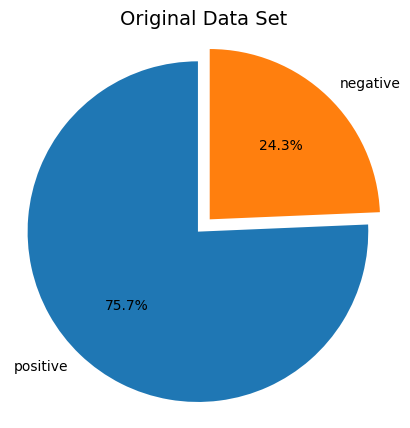

In [5]:
fig1, ax1 = plt.subplots(figsize=(5,5))

labels = ['positive', 'negative']
sizes = [len(tweet_collection[tweet_collection['Label'] == 'positive']), len(tweet_collection[tweet_collection['Label'] == 'negative'])]
explode = (0, 0.1)  # only "explode" the 2nd slice

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Original Data Set", fontsize=14)
    
plt.show()

In [6]:
positive_comments = tweet_collection[tweet_collection['Label'] == "positive"]
negative_comments = tweet_collection[tweet_collection['Label'] == "negative"]

In [7]:
#!pip install WordCloud
from wordcloud import WordCloud

In [8]:
sentences = tweet_collection['Tweet'].tolist()
joined_sentences = ' '.join(sentences)

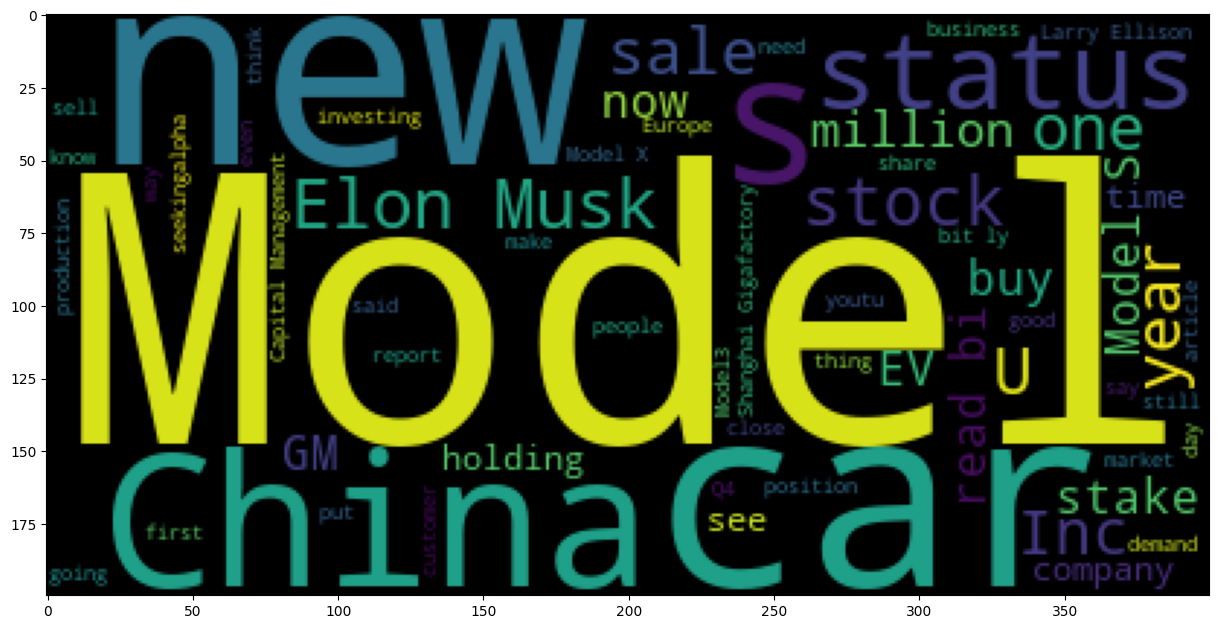

In [9]:
from wordcloud import STOPWORDS

pos_sentences = positive_comments['Tweet'].tolist()
stop_words = ['Tesla', 'TSLA', 'twitter', 'https', 'elonmusk', 'TSLAQ', 'will', 'pic'] + list(STOPWORDS)
joined_pos_sentences = ' '.join(pos_sentences)
plt.figure(figsize=(15,15))
plt.imshow(WordCloud(stopwords = stop_words).generate(joined_pos_sentences))

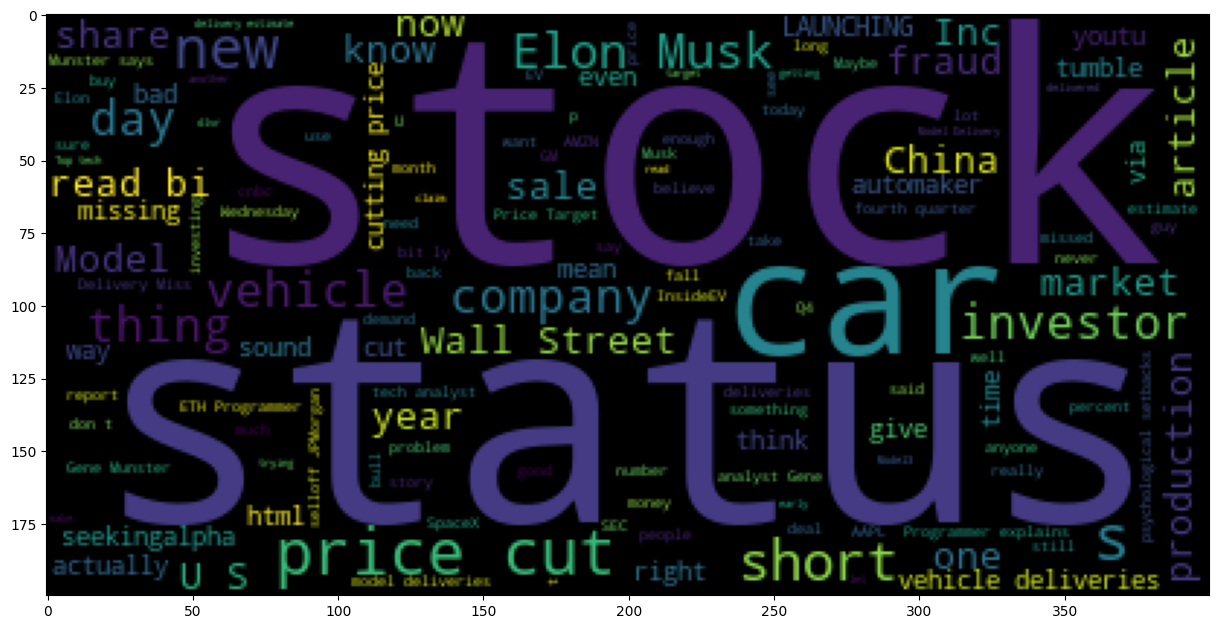

In [10]:
neg_sentences = negative_comments['Tweet'].tolist()                     #convert the tweets into list
stop_words = ['Tesla', 'TSLA', 'twitter', 'https', 'elonmusk', 'TSLAQ', 'will', 'pic'] + list(STOPWORDS)
joined_neg_sentences = ' '.join(neg_sentences)            #join all the sentences into one string
plt.figure(figsize=(15,15))
plt.imshow(WordCloud(stopwords = stop_words).generate(joined_neg_sentences))

# Training and Test Set

In [11]:
# Randomize the entire data set
tweet_df = tweet_collection[:5000]
randomized_collection = tweet_df.sample(frac=1, random_state=3)

# Calculate index for split
training_test_index = round(len(randomized_collection) * 0.8)

# Training/Test split
training_set = randomized_collection[:training_test_index].reset_index(drop=True)
test_set = randomized_collection[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4000, 4)
(1000, 4)


In [12]:
print(training_set['Label'].value_counts(normalize = True))
test_set['Label'].value_counts(normalize = True)

Label
positive    0.755128
negative    0.244872
Name: proportion, dtype: float64


Label
positive    0.763
negative    0.237
Name: proportion, dtype: float64

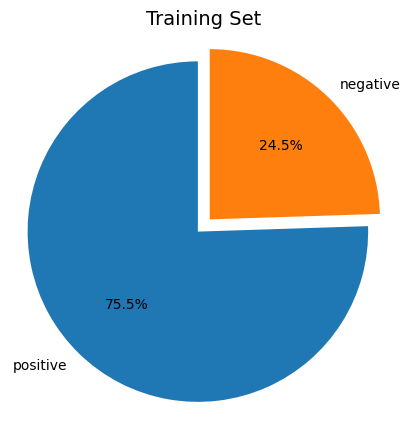

In [13]:
fig2, ax2 = plt.subplots(figsize=(5,5))

labels = ['positive', 'negative']
sizes = [len(training_set[training_set['Label'] == 'positive']), len(training_set[training_set['Label'] == 'negative'])]
explode = (0, 0.1)  # only "explode" the 2nd slice

ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title("Training Set", fontsize=14)
    
plt.show()

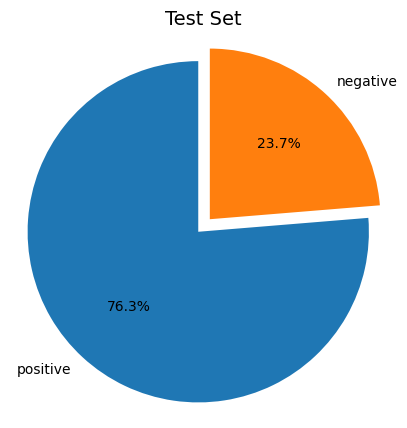

In [14]:
fig3, ax3 = plt.subplots(figsize=(5,5))

labels = ['positive', 'negative']
sizes = [len(test_set[test_set['Label'] == 'positive']), len(test_set[test_set['Label'] == 'negative'])]
explode = (0, 0.1)  # only "explode" the 2nd slice

ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax3.set_title("Test Set", fontsize=14)
    
plt.show()

# Model Development

# Data Pre-Processing

In [15]:
# Original training set - before processing
training_set.head()

,ID,Label,Tweet,Date
0,1082561795053813762,negative,Tesla Inc $TSLA Receives $331.23 Consensus Tar...,2019-01-08 03:56:59
1,1084934178708353024,negative,$TSLA - This is a big deal for apartment rente...,2019-01-14 17:03:59
2,1085289896812691457,positive,Curious about #Tesla's next move for #ModelS. ...,2019-01-15 16:37:29
3,1083496016232529920,positive,"2019 BMW 320i Sedan Base: $40,250 Various pack...",2019-01-10 17:49:15
4,1080550582488715265,positive,Tesla's core business of selling Model S and M...,2019-01-02 14:45:09


# Normalization

In [16]:
import pandas as pd
import re

# Assuming 'training_set' is already defined

# Define a function for preprocessing
def preprocess_tweet(tweet):
    tweet = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', ' ', tweet)
    tweet = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', ' ', tweet)
    tweet = re.sub(r'£|\$', ' ', tweet)
    tweet = re.sub(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', ' ', tweet)
    tweet = re.sub(r'\d+(\.\d+)?', ' ', tweet)
    tweet = re.sub(r'[^\w\s]', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip().lower()
    return tweet

# Apply preprocessing to the 'Tweet' column
training_set['Tweet'] = training_set['Tweet'].apply(lambda tweet: preprocess_tweet(tweet))

# Print the processed DataFrame
print(training_set['Tweet'])


0       tesla inc tsla receives consensus target price...
1       tsla this is a big deal for apartment renters ...
2       curious about tesla s next move for models kwh...
3       bmw i sedan base various packages to bring the...
4       tesla s core business of selling model s and m...
                              ...                        
3995    operationsnapshot you guys are a parody group ...
3996    nomura expects opportunity to buy tesla shares...
3997                            tesla fud tax credit tsla
3998    things to know elon musk may be trying to cut ...
3999    i m not much of an investor but the performanc...
Name: Tweet, Length: 4000, dtype: object


In [17]:
training_set.head()

,ID,Label,Tweet,Date
0,1082561795053813762,negative,tesla inc tsla receives consensus target price...,2019-01-08 03:56:59
1,1084934178708353024,negative,tsla this is a big deal for apartment renters ...,2019-01-14 17:03:59
2,1085289896812691457,positive,curious about tesla s next move for models kwh...,2019-01-15 16:37:29
3,1083496016232529920,positive,bmw i sedan base various packages to bring the...,2019-01-10 17:49:15
4,1080550582488715265,positive,tesla s core business of selling model s and m...,2019-01-02 14:45:09


# Removing Stopwords

In [18]:
#!pip install nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = nltk.corpus.stopwords.words('english')

In [19]:
training_set['Tweet'] = training_set['Tweet'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in set(stop_words))
)

In [20]:
training_set.head()

,ID,Label,Tweet,Date
0,1082561795053813762,negative,tesla inc tsla receives consensus target price...,2019-01-08 03:56:59
1,1084934178708353024,negative,tsla big deal apartment renters wait jump tesla,2019-01-14 17:03:59
2,1085289896812691457,positive,curious tesla next move models kwh disappeared...,2019-01-15 16:37:29
3,1083496016232529920,positive,bmw sedan base various packages bring experien...,2019-01-10 17:49:15
4,1080550582488715265,positive,tesla core business selling model model x vehi...,2019-01-02 14:45:09


# Lemmatization

In [21]:
#nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()
training_set['Tweet'] = training_set['Tweet'].apply(lambda x: ' '.join(
    lemmatizer.lemmatize(term, pos='v') for term in x.split())
)

In [22]:
training_set.head()

,ID,Label,Tweet,Date
0,1082561795053813762,negative,tesla inc tsla receive consensus target price ...,2019-01-08 03:56:59
1,1084934178708353024,negative,tsla big deal apartment renters wait jump tesla,2019-01-14 17:03:59
2,1085289896812691457,positive,curious tesla next move model kwh disappear de...,2019-01-15 16:37:29
3,1083496016232529920,positive,bmw sedan base various package bring experienc...,2019-01-10 17:49:15
4,1080550582488715265,positive,tesla core business sell model model x vehicle...,2019-01-02 14:45:09


# Stemming

In [23]:
porter = nltk.PorterStemmer()
training_set['Tweet'] = training_set['Tweet'].apply(lambda x: ' '.join(
    porter.stem(term) for term in x.split())
)

In [24]:
training_set.head()

,ID,Label,Tweet,Date
0,1082561795053813762,negative,tesla inc tsla receiv consensu target price an...,2019-01-08 03:56:59
1,1084934178708353024,negative,tsla big deal apart renter wait jump tesla,2019-01-14 17:03:59
2,1085289896812691457,positive,curiou tesla next move model kwh disappear des...,2019-01-15 16:37:29
3,1083496016232529920,positive,bmw sedan base variou packag bring experi litt...,2019-01-10 17:49:15
4,1080550582488715265,positive,tesla core busi sell model model x vehicl hold...,2019-01-02 14:45:09


# Tokenization

In [25]:
#nltk.download('punkt')
training_set['Tweet'] = training_set['Tweet'].apply(lambda Tweet: nltk.word_tokenize(Tweet))

In [26]:
training_set.head()

,ID,Label,Tweet,Date
0,1082561795053813762,negative,"[tesla, inc, tsla, receiv, consensu, target, p...",2019-01-08 03:56:59
1,1084934178708353024,negative,"[tsla, big, deal, apart, renter, wait, jump, t...",2019-01-14 17:03:59
2,1085289896812691457,positive,"[curiou, tesla, next, move, model, kwh, disapp...",2019-01-15 16:37:29
3,1083496016232529920,positive,"[bmw, sedan, base, variou, packag, bring, expe...",2019-01-10 17:49:15
4,1080550582488715265,positive,"[tesla, core, busi, sell, model, model, x, veh...",2019-01-02 14:45:09


# Feature Extraction

# Vectorization

In [27]:
corpus = training_set['Tweet'].sum()

In [28]:
len(corpus)

63513

In [29]:
# Transform the list to a set, to remove duplicates
temp_set = set(corpus)

# Revert to a list
vocabulary = list(temp_set)

In [30]:
len(vocabulary)

6276

In [31]:
# Create the dictionary
len_training_set = len(training_set['Tweet'])
word_counts_per_sms = {unique_word: [0] * len_training_set for unique_word in vocabulary}

for index, sms in enumerate(training_set['Tweet']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [32]:
# Convert to dataframe
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,rate,center,pari,interweb,goog,differenti,communist,honestli,clyde,boy,...,pvg,readi,desper,harm,shell,scrap,fact,livetradingnew,exert,gear
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
word_counts.shape

(4000, 6276)

In [34]:
# Concatenate with the original training set
training_set_final = pd.concat([training_set, word_counts], axis=1)
training_set_final.head()

,ID,Label,Tweet,Date,rate,center,pari,interweb,goog,differenti,...,pvg,readi,desper,harm,shell,scrap,fact,livetradingnew,exert,gear
0,1082561795053813762,negative,"[tesla, inc, tsla, receiv, consensu, target, p...",2019-01-08 03:56:59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1084934178708353024,negative,"[tsla, big, deal, apart, renter, wait, jump, t...",2019-01-14 17:03:59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1085289896812691457,positive,"[curiou, tesla, next, move, model, kwh, disapp...",2019-01-15 16:37:29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1083496016232529920,positive,"[bmw, sedan, base, variou, packag, bring, expe...",2019-01-10 17:49:15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1080550582488715265,positive,"[tesla, core, busi, sell, model, model, x, veh...",2019-01-02 14:45:09,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Calculating Constants First

In [35]:
# Filter the positive and negative dataframes
spam_df = training_set_final[training_set_final['Label'] == 'positive'].copy()
ham_df = training_set_final[training_set_final['Label'] == 'negative'].copy()

In [36]:
# Calculate P(Spam) and P(Ham)
p_spam = spam_df.shape[0] / training_set_final.shape[0]
p_ham = ham_df.shape[0] / training_set_final.shape[0]

In [37]:
print(p_spam)
p_ham

0.75475


0.24475

In [38]:
# Calculate Nspam, Nham and Nvocabulary
spam_words_per_message = spam_df['Tweet'].apply(len)
n_spam = spam_words_per_message.sum()

ham_words_per_message = ham_df['Tweet'].apply(len)
n_ham = ham_words_per_message.sum()

n_vocabulary = len(vocabulary)

In [39]:
# Opting for the Laplace smoothing
alpha = 1

# Calculating Parameters

In [40]:
# Create two dictionaries that match each unique word with the respective probability value.
parameters_spam = {unique_word: 0 for unique_word in vocabulary}
parameters_ham = {unique_word: 0 for unique_word in vocabulary}

# Iterate over the vocabulary and for each word, calculate P(wi|Spam) and P(wi|Ham)
for unique_word in vocabulary:
    p_unique_word_spam = (spam_df[unique_word].sum() + alpha) / (n_spam + alpha * n_vocabulary)
    p_unique_word_ham = (ham_df[unique_word].sum() + alpha) / (n_ham + alpha * n_vocabulary)
    
    # Update the calculated propabilities to the dictionaries
    parameters_spam[unique_word] = p_unique_word_spam
    parameters_ham[unique_word] = p_unique_word_ham

# Classifying a New Message

In [41]:
def sms_classify(message):
    '''
    Takes in as input a new sms (w1, w2, ..., wn),
    calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn),
    compares them and outcomes whether the message is spam or not.
    '''
    
    # Replace addresses (hhtp, email), numbers (plain, phone), money symbols
    message = message.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', ' ')
    message = message.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', ' ')
    message = message.replace(r'£|\$', ' ')    
    message = message.replace(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', ' ')    
    message = message.replace(r'\d+(\.\d+)?', ' ')

    # Remove punctuation, collapse all whitespace (spaces, line breaks, tabs) into a single space & eliminate any leading/trailing whitespace.
    message = message.replace(r'[^\w\d\s]', ' ')
    message = message.replace(r'\s+', ' ')
    message = message.replace(r'^\s+|\s+?$', '')

    # Lowercase the entire corpus
    message = message.lower()

    # Remove stop words    
    terms = []
    for term in message.split():
        if term not in set(stop_words):
            terms.append(term)
            message = ' '.join(terms)

    # Lemmatization
    message = ' '.join(lemmatizer.lemmatize(term, pos='v') for term in message.split())            
            
    # Stemming
    message = ' '.join(porter.stem(term) for term in message.split())  
    
    # Tokenization
    message = message.split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
    
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    
    print('P(positive|tweet):', p_spam_given_message)
    print('P(negative|tweet):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Negative')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Positive')
    else:
        print('Equal probabilities ~ Human action needed!')

In [42]:
sms_classify('TESLA SHARES EXTEND LOSS TO 4.2% ON 4Q DELIVERIES, PRICE CUTS')

P(positive|tweet): 3.221247948231416e-17
P(negative|tweet): 4.0936142824920013e-16
Label: Negative


# Measuring the Spam Filter's Accuray

In [43]:
# We define the classify () function again, this time returning the outcomes
def sms_classify_test_set(message):
    '''
    Takes in as input a new sms (w1, w2, ..., wn),
    calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn),
    compares them and returns the spam or ham label, respectively.
    '''
    
    # Replace addresses (hhtp, email), numbers (plain, phone), money symbols
    message = message.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', ' ')
    message = message.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', ' ')
    message = message.replace(r'£|\$', ' ')    
    message = message.replace(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', ' ')    
    message = message.replace(r'\d+(\.\d+)?', ' ')

    # Remove punctuation, collapse all whitespace (spaces, line breaks, tabs) into a single space & eliminate any leading/trailing whitespace.
    message = message.replace(r'[^\w\d\s]', ' ')
    message = message.replace(r'\s+', ' ')
    message = message.replace(r'^\s+|\s+?$', '')

    # Lowercase the entire corpus
    message = message.lower()
    
    # Remove stop words    
    terms = []
    for term in message.split():
        if term not in set(stop_words):
            terms.append(term)
            message = ' '.join(terms)
    
    # Lemmatization
    message = ' '.join(lemmatizer.lemmatize(term, pos='v') for term in message.split())
    
    # Stemming
    message = ' '.join(porter.stem(term) for term in message.split())
    
    # Tokenization
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    if p_ham_given_message > p_spam_given_message:
        return 'negative' + ' ' + str(p_spam_given_message)
    elif p_spam_given_message > p_ham_given_message:
        return 'positive' + ' ' + str(p_spam_given_message)
    else:
        return 'needs human classification'

In [44]:
test_set['Label_predicted'] = test_set['Tweet'].apply(sms_classify_test_set)
test_set.head()

,ID,Label,Tweet,Date,Label_predicted
0,1081045637578276864,positive,"+100 #Transit, #LastMile #Taxi, #Taxis Div. Of...",2019-01-03 23:32:19,positive 9.729567310820351e-11
1,1083484458249084929,positive,"Tesla Motors Inc (TSLA) price at close, 2019-0...",2019-01-10 17:03:19,positive 1.3883851914147798e-09
2,1081997538226462720,positive,If I'm understanding this correctly each EV ha...,2019-01-06 14:34:50,positive 7.930867146005342e-62
3,1080459377985945601,negative,"Tesla $TSLA delivered 90,700 in Q4, 8% above Q...",2019-01-02 08:42:44,positive 9.283103394071228e-40
4,1080473043233837056,negative,Tesla 4Q 2018 delivery numbers fall short $TSL...,2019-01-02 09:37:02,negative 4.34710157391139e-14


In [45]:
tweet_collection['Label_predicted'] = tweet_collection['Tweet'].apply(sms_classify_test_set)
tweet_collection.head()

,ID,Label,Tweet,Date,Label_predicted
0,1079985739482443778,positive,The competition wishes. This does not happen w...,2019-01-01 01:20:40,positive 3.951564752468494e-09
1,1079988965418110976,positive,A little late cuz I just got home but happy ne...,2019-01-01 01:33:29,positive 1.4012042100381057e-61
2,1079990351824371712,positive,Tesla: Down to the Wire @VickiBryanBondA $TSLA...,2019-01-01 01:38:59,positive 9.837538404245416e-05
3,1079992268545609728,positive,"Happy Never Going Bankrupt Eve, $TSLAQ! $TSLA...",2019-01-01 01:46:36,positive 9.950242507037349e-14
4,1079993076511318016,positive,My 1st tweet of 2019 goes to Tesla $TSLA but I...,2019-01-01 01:49:49,positive 5.176403597736338e-24


In [46]:
tweet_collection[['Label_pred', 'Probabilities']] = tweet_collection.Label_predicted.str.split(expand=True)

In [47]:
tweet_collection['new_prob'] = pd.to_numeric(tweet_collection['Probabilities'])
tweet_collection.head()

,ID,Label,Tweet,Date,Label_predicted,Label_pred,Probabilities,new_prob
0,1079985739482443778,positive,The competition wishes. This does not happen w...,2019-01-01 01:20:40,positive 3.951564752468494e-09,positive,3.951564752468494e-09,3.951565e-09
1,1079988965418110976,positive,A little late cuz I just got home but happy ne...,2019-01-01 01:33:29,positive 1.4012042100381057e-61,positive,1.4012042100381057e-61,1.401204e-61
2,1079990351824371712,positive,Tesla: Down to the Wire @VickiBryanBondA $TSLA...,2019-01-01 01:38:59,positive 9.837538404245416e-05,positive,9.837538404245416e-05,9.837538e-05
3,1079992268545609728,positive,"Happy Never Going Bankrupt Eve, $TSLAQ! $TSLA...",2019-01-01 01:46:36,positive 9.950242507037349e-14,positive,9.950242507037349e-14,9.950243e-14
4,1079993076511318016,positive,My 1st tweet of 2019 goes to Tesla $TSLA but I...,2019-01-01 01:49:49,positive 5.176403597736338e-24,positive,5.176403597736338e-24,5.176404e-24


In [48]:
tweet_collection['SUM'] = tweet_collection.groupby('Date').sum('new_prob')
tweet_collection.head()

,ID,Label,Tweet,Date,Label_predicted,Label_pred,Probabilities,new_prob,SUM
0,1079985739482443778,positive,The competition wishes. This does not happen w...,2019-01-01 01:20:40,positive 3.951564752468494e-09,positive,3.951564752468494e-09,3.951565e-09,NaN
1,1079988965418110976,positive,A little late cuz I just got home but happy ne...,2019-01-01 01:33:29,positive 1.4012042100381057e-61,positive,1.4012042100381057e-61,1.401204e-61,NaN
2,1079990351824371712,positive,Tesla: Down to the Wire @VickiBryanBondA $TSLA...,2019-01-01 01:38:59,positive 9.837538404245416e-05,positive,9.837538404245416e-05,9.837538e-05,NaN
3,1079992268545609728,positive,"Happy Never Going Bankrupt Eve, $TSLAQ! $TSLA...",2019-01-01 01:46:36,positive 9.950242507037349e-14,positive,9.950242507037349e-14,9.950243e-14,NaN
4,1079993076511318016,positive,My 1st tweet of 2019 goes to Tesla $TSLA but I...,2019-01-01 01:49:49,positive 5.176403597736338e-24,positive,5.176403597736338e-24,5.176404e-24,NaN


<Axes: xlabel='Date'>

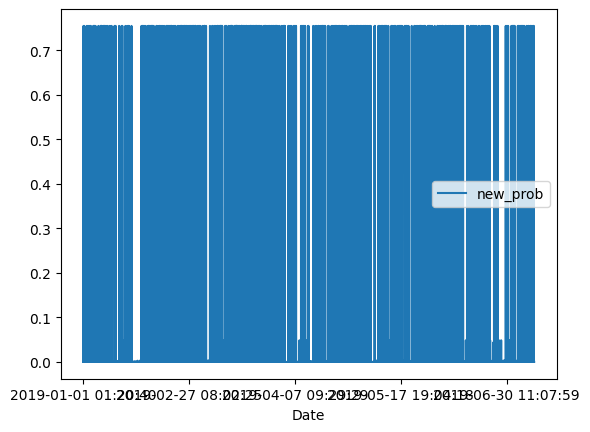

In [49]:
tweet_collection.plot(kind='line',x='Date',y='new_prob')

In [50]:
# Read in data
tsla_stock = pd.read_csv('TSLA.csv', names=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], header=1)
print(tsla_stock.shape)
tsla_stock.head()

(132, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
1,2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2,2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
3,2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500
4,2019-01-09,22.366667,22.900000,22.098000,22.568666,22.568666,81493500


In [54]:
# Format the new_prob column to display numbers without scientific notation
tweet_collection['new_prob_formatted'] = tweet_collection['new_prob'].apply(lambda x: '{:.20f}'.format(x))

# Convert the formatted strings back to float
tweet_collection['new_prob'] = tweet_collection['new_prob_formatted'].astype(float)

# Convert 'Date' column to datetime
tweet_collection['Date'] = pd.to_datetime(tweet_collection['Date'])

# Extract date portion (YYYY-MM-DD)
tweet_collection['Date'] = tweet_collection['Date'].dt.date

# Now you can perform the groupby operation
means = tweet_collection.groupby(['Date'], as_index=False)['new_prob'].mean()

means['Date'] = pd.to_datetime(means['Date'])
tsla_stock['Date'] = pd.to_datetime(tsla_stock['Date'])

#print("Data type of 'Date' column in means DataFrame:", means['Date'].dtype)
#print("Data type of 'Date' column in tsla_stock DataFrame:", tsla_stock['Date'].dtype)


In [55]:
means['Date'] = means['Date'].dt.strftime('%Y-%m-%d')
tsla_stock['Date'] = tsla_stock['Date'].dt.strftime('%Y-%m-%d')

In [56]:
#means = tweet_collection.groupby(['Date'],  as_index=False).mean()

# Merge with 'tsla_stock' DataFrame
combined = means.merge(tsla_stock, how='inner', on='Date')

# Print common rows fetched
#print("Common rows fetched after merging:")
#print(combined)


In [57]:
# Calculate the correlation between 'new_prob' and 'Close'
correlation = combined['new_prob'].corr(combined['Close'])
print("Correlation between 'new_prob' and 'Close':", correlation)

Correlation between 'new_prob' and 'Close': 0.0362264071264293


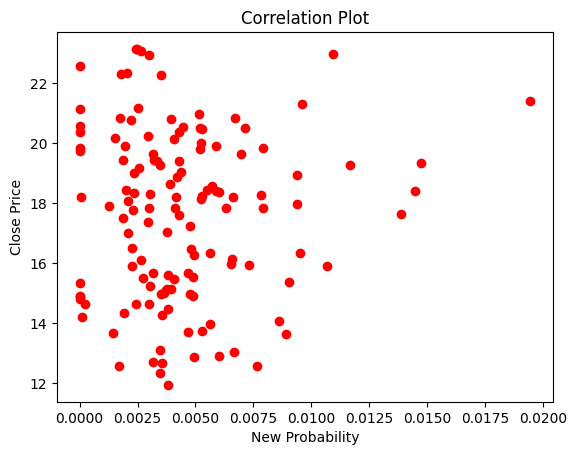

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plot the data
fig, ax = plt.subplots(1)
ax.plot(combined['new_prob'], combined['Close'], 'ro')
ax.set_xlabel('New Probability')
ax.set_ylabel('Close Price')
ax.set_title('Correlation Plot')
plt.show()


In [59]:
# Extract the label part from 'Label_predicted'
test_set['Predicted_Label'] = test_set['Label_predicted'].apply(lambda x: x.split()[0])

# Calculate accuracy
correct = sum(test_set['Label'] == test_set['Predicted_Label'])
total = test_set.shape[0]

print('Results \n-------')
print('Valid:', correct)
print('Invalid:', total - correct)
print('Accuracy:', round(correct / total, 4))


Results 
-------
Valid: 898
Invalid: 102
Accuracy: 0.898


In [60]:
from sklearn import metrics

# Extracting only the predicted labels from 'Label_predicted' column
test_set['Predicted_Label'] = test_set['Label_predicted'].str.split(' ', n=1).str[0]

# Compute the confusion matrix using the actual labels and the predicted labels
confusion = metrics.confusion_matrix(test_set['Label'], test_set['Predicted_Label'])
print(confusion)


[[159  78]
 [ 24 739]]


# Classifying rest of the data

In [61]:
tweet_collection['Label_predicted'] = tweet_collection['Tweet'].apply(sms_classify_test_set)
tweet_collection.head()

,ID,Label,Tweet,Date,Label_predicted,Label_pred,Probabilities,new_prob,SUM,new_prob_formatted
0,1079985739482443778,positive,The competition wishes. This does not happen w...,2019-01-01,positive 3.951564752468494e-09,positive,3.951564752468494e-09,3.951565e-09,NaN,0.00000000395156475247
1,1079988965418110976,positive,A little late cuz I just got home but happy ne...,2019-01-01,positive 1.4012042100381057e-61,positive,1.4012042100381057e-61,0.000000e+00,NaN,0.00000000000000000000
2,1079990351824371712,positive,Tesla: Down to the Wire @VickiBryanBondA $TSLA...,2019-01-01,positive 9.837538404245416e-05,positive,9.837538404245416e-05,9.837538e-05,NaN,0.00009837538404245416
3,1079992268545609728,positive,"Happy Never Going Bankrupt Eve, $TSLAQ! $TSLA...",2019-01-01,positive 9.950242507037349e-14,positive,9.950242507037349e-14,9.950243e-14,NaN,0.00000000000009950243
4,1079993076511318016,positive,My 1st tweet of 2019 goes to Tesla $TSLA but I...,2019-01-01,positive 5.176403597736338e-24,positive,5.176403597736338e-24,0.000000e+00,NaN,0.00000000000000000000


In [62]:
tweet_collection[['Label_pred', 'Probabilities']] = tweet_collection.Label_predicted.str.split(expand=True)
# new_df = tweet_collection.groupby(['D'])
# new_df.head()
# print(new_df['D'] == '2019-01-01')

In [63]:
tweet_collection.head()
tweet_collection['new_prob'] = pd.to_numeric(tweet_collection['Probabilities'])

<Axes: xlabel='Date'>

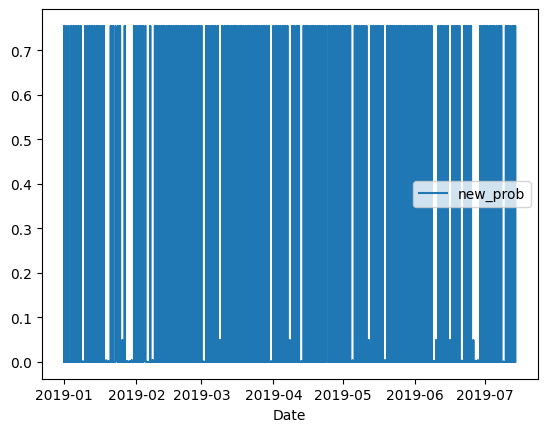

In [64]:
tweet_collection.plot(kind='line',x='Date',y='new_prob')

0.0362264071264293


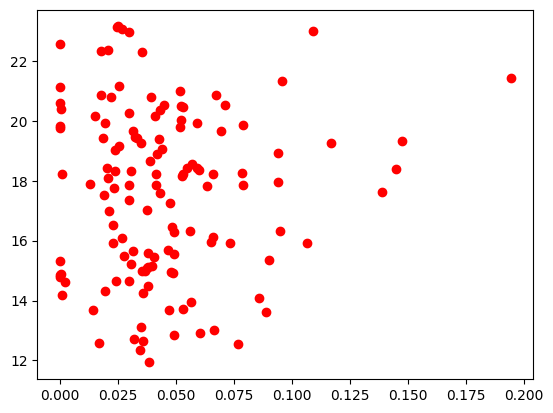

In [65]:
#means = tweet_collection.groupby(['Date'],  as_index=False).mean()
combined = means.merge(tsla_stock, how='inner')

print(combined['new_prob'].corr(combined['Close']))

import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# plot the data
ax.plot(combined['new_prob']*10,combined['Close'], 'ro')

# Additional Methods for Sentimental Analysis

# Logistic Regression

In [66]:
def build_freqs(tweets, ys):
  yslist = np.squeeze(ys).tolist()

  freqs = {}
  for y, tweet in zip(yslist, tweets):
    for word in tweet:
      pair = (word, y)
      if pair in freqs:
        freqs[pair]+=1
      else:
        freqs[pair] =1
  return freqs

In [67]:
train_pos = training_set[training_set['Label'] == "positive"]
train_neg = training_set[training_set['Label'] == "negative"]

train_x = training_set['Tweet']
print(type(train_pos))

#train_x1 = pd.concat(train_pos, train_neg)
#print(train_x1)
train_y = training_set['Label']



<class 'pandas.core.frame.DataFrame'>


In [68]:
test_pos = test_set[test_set['Label'] == "positive"]
test_neg = test_set[test_set['Label'] == "negative"]

test_x = test_set['Tweet']
test_y = test_set['Label']


In [69]:
train_y[train_y == 'positive'] = 1
train_y[train_y == 'negative'] = 0
#train_y = train_y.replace(['positive'],1)
#train_y = train_y.replace(['negative'],0)

train_y0 = train_y.fillna(0)
print(train_y0.unique())

#train_y = train_y.astype(int)
train_y1 = train_y0.to_numpy()
#np.transpose(train_y1)
train_y2 = []
for i in train_y1:
    train_y2.append([i])
    
train_y3 = np.array(train_y2)

[0 1]


In [70]:
test_y[test_y == 'positive'] = 1
test_y[test_y == 'negative'] = 0
#train_y = train_y.replace(['positive'],1)
#train_y = train_y.replace(['negative'],0)

test_y0 = test_y.fillna(0)
print(test_y0.unique())

#train_y = train_y.astype(int)
test_y1 = test_y0.to_numpy()
#np.transpose(train_y1)
test_y2 = []
for i in test_y1:
    test_y2.append([i])
    
test_y3 = np.array(test_y2)

[1 0]


In [71]:
# create a frequency dictionary
freqs = build_freqs(train_x, train_y3)

print('Type of freqs : ', type(freqs))
print('Length of freqs : ', len(freqs))

Type of freqs :  <class 'dict'>
Length of freqs :  8477


In [72]:
def sigmoid(z):
    h = 1/(1+np.exp(-z))
    return h

In [73]:
def gradientDescent(x, y, theta, alp, iterations):
    m = x.shape[0]
    for i in range(iterations):
        z = np.dot(x, theta)
        h = sigmoid(z)

        # cost function
        j = (-1/m) * (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h)))
        
        # update the weights theta
        theta = theta - (alp/m)* (np.dot(x.T, h-y))
        
    j = float(j)
    return j,theta

In [74]:
def extract_features(tweet, freqs):

  # Process the tweet
  word_l = tweet

  x = np.zeros((1, 3))

  # bias term is set to 1
  x[0, 0] = 1

  for word in word_l:
    x[0, 1] += freqs.get((word, 1), 0)
    x[0, 2] += freqs.get((word, 0), 0)

  assert(x.shape==(1, 3))
  return x

In [75]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
  X[i, :] = extract_features(train_x[i], freqs)

# training levels corrosponding to X
Y = train_y3

# Applying Gradient Descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)

print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.55259964.
The resulting vector of weights is [2e-08, 0.00014217, -1.172e-05]


C:\Users\HP\AppData\Local\Temp\ipykernel_29220\1241948527.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = float(j)


In [76]:
testing_set = test_set
print(testing_set)

                      ID Label  \
0    1081045637578276864     1   
1    1083484458249084929     1   
2    1081997538226462720     1   
3    1080459377985945601     0   
4    1080473043233837056     0   
..                   ...   ...   
995  1080575719938367489     1   
996  1080751033196769280     1   
997  1081340201270738944     1   
998  1083380942230691841     1   
999  1081359163379179523     1   

                                                 Tweet                 Date  \
0    +100 #Transit, #LastMile #Taxi, #Taxis Div. Of...  2019-01-03 23:32:19   
1    Tesla Motors Inc (TSLA) price at close, 2019-0...  2019-01-10 17:03:19   
2    If I'm understanding this correctly each EV ha...  2019-01-06 14:34:50   
3    Tesla $TSLA delivered 90,700 in Q4, 8% above Q...  2019-01-02 08:42:44   
4    Tesla 4Q 2018 delivery numbers fall short $TSL...  2019-01-02 09:37:02   
..                                                 ...                  ...   
995  What stays of today?  👉 Tesla nev

In [77]:
import pandas as pd
import re

# Assuming 'training_set' is already defined

# Define a function for preprocessing
def preprocess_tweet(tweet):
    tweet = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', ' ', tweet)
    tweet = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', ' ', tweet)
    tweet = re.sub(r'£|\$', ' ', tweet)
    tweet = re.sub(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', ' ', tweet)
    tweet = re.sub(r'\d+(\.\d+)?', ' ', tweet)
    tweet = re.sub(r'[^\w\s]', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip().lower()
    return tweet

# Apply preprocessing to the 'Tweet' column
testing_set['Tweet'] = testing_set['Tweet'].apply(lambda tweet: preprocess_tweet(tweet))

# Print the processed DataFrame
print(testing_set['Tweet'])



0      transit lastmile taxi taxis div of the surging...
1                tesla motors inc tsla price at close is
2      if i m understanding this correctly each ev ha...
3      tesla tsla delivered in q above q mr market is...
4               tesla q delivery numbers fall short tsla
                             ...                        
995    what stays of today tesla never achieved k wk ...
996    tesla s net losses each year sec k q mil q q m...
997    elon musk reportedly deleted a tweet linking t...
998    f to close production plants in europe not a g...
999    my point is of tesla after chapter might cost ...
Name: Tweet, Length: 1000, dtype: object


In [78]:
testing_set['Tweet'] = testing_set['Tweet'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in set(stop_words))
)

In [79]:
lemmatizer = nltk.stem.WordNetLemmatizer()
testing_set['Tweet'] = testing_set['Tweet'].apply(lambda x: ' '.join(
    lemmatizer.lemmatize(term, pos='v') for term in x.split())
)

In [80]:
porter = nltk.PorterStemmer()
testing_set['Tweet'] = testing_set['Tweet'].apply(lambda x: ' '.join(
    porter.stem(term) for term in x.split())
)

In [81]:
testing_set['Tweet'] = testing_set['Tweet'].apply(lambda Tweet: nltk.word_tokenize(Tweet))

In [82]:
testing_set.head()

,ID,Label,Tweet,Date,Label_predicted,Predicted_Label
0,1081045637578276864,1,"[transit, lastmil, taxi, taxi, div, surg, glob...",2019-01-03 23:32:19,positive 9.729567310820351e-11,positive
1,1083484458249084929,1,"[tesla, motor, inc, tsla, price, close]",2019-01-10 17:03:19,positive 1.3883851914147798e-09,positive
2,1081997538226462720,1,"[understand, correctli, ev, type, specif, char...",2019-01-06 14:34:50,positive 7.930867146005342e-62,positive
3,1080459377985945601,0,"[tesla, tsla, deliv, q, q, mr, market, happi, ...",2019-01-02 08:42:44,positive 9.283103394071228e-40,positive
4,1080473043233837056,0,"[tesla, q, deliveri, number, fall, short, tsla]",2019-01-02 09:37:02,negative 4.34710157391139e-14,negative


In [83]:
def predict_tweet(tweet, freqs, theta):

  x = extract_features(tweet, freqs) 

  # make prediction
  y_pred = sigmoid(np.dot(x, theta))

  return y_pred

In [84]:
def test_logistic_regression(test_x, test_y, freqs, theta):

  # empty list for storing predictions
    y_hat = []
    count = 0
    for tweet in test_x:
        y_pred = predict_tweet(tweet, freqs, theta)
        count += 1
        if y_pred >0.5:
            y_hat.append(1)
        else:
            y_hat.append(0)
    accuracy = (y_hat==np.squeeze(test_y)).sum()/len(test_x)
    return accuracy 
accuracy = test_logistic_regression(test_x, test_y3, freqs, theta)
print('The accuracy of Logistic Regression is :', accuracy)

The accuracy of Logistic Regression is : 0.763


In [85]:
train_x.head()

0    [tesla, inc, tsla, receiv, consensu, target, p...
1    [tsla, big, deal, apart, renter, wait, jump, t...
2    [curiou, tesla, next, move, model, kwh, disapp...
3    [bmw, sedan, base, variou, packag, bring, expe...
4    [tesla, core, busi, sell, model, model, x, veh...
Name: Tweet, dtype: object

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure 'Tweet' column is in the correct format
training_set['Tweet'] = training_set['Tweet'].astype(str)

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english")

# Fit and transform the data
tweet_mat = vectorizer.fit_transform(training_set['Tweet'])

# Display the transformed data
tweet_mat


<4000x6136 sparse matrix of type '<class 'numpy.float64'>'
	with 54005 stored elements in Compressed Sparse Row format>

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure 'Tweet' column is in the correct format
testing_set['Tweet'] = testing_set['Tweet'].astype(str)

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english")

# Fit and transform the data
testing_mat = vectorizer.fit_transform(testing_set['Tweet'])

# Display the transformed data
testing_mat


<1000x3069 sparse matrix of type '<class 'numpy.float64'>'
	with 13226 stored elements in Compressed Sparse Row format>

In [89]:
tweet_train, tweet_test, pos_neg_train, pos_neg_test = train_test_split(tweet_mat, train_y3, test_size=0.3, random_state=20)   

In [90]:
logistic_model = LogisticRegression(solver='liblinear', penalty='l1')
logistic_model.fit(tweet_train, pos_neg_train)
pred = logistic_model.predict(tweet_test)
score = accuracy_score(pos_neg_test, pred)
score


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8425

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [92]:
cm = metrics.confusion_matrix(pos_neg_test, pred)
print(cm)

[[120 172]
 [ 17 891]]


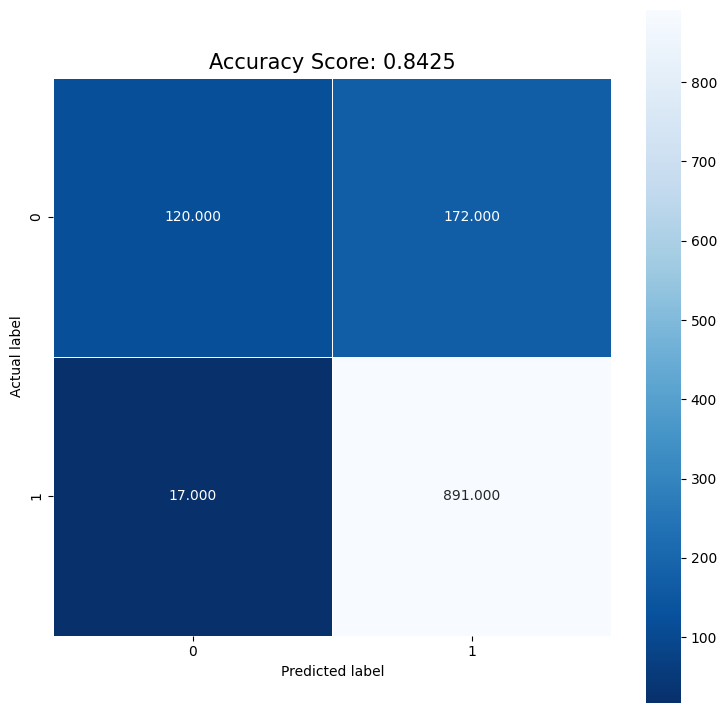

In [93]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Gradient Boost Classifier

In [94]:
from sklearn.ensemble import GradientBoostingClassifier

In [95]:
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(tweet_train, pos_neg_train)
pred1 = clf1.predict(tweet_test)
gradientboosting_score = accuracy_score(pos_neg_test, pred1)
gradientboosting_score

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8166666666666667

In [96]:
cm1 = metrics.confusion_matrix(pos_neg_test, pred1)
print(cm1)

[[152 140]
 [ 80 828]]


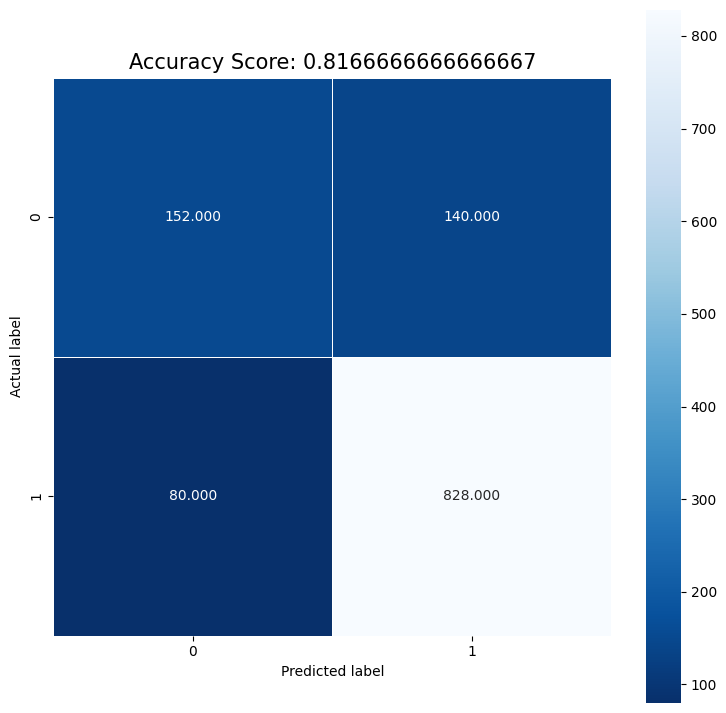

In [97]:
plt.figure(figsize=(9,9))
sns.heatmap(cm1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(gradientboosting_score)
plt.title(all_sample_title, size = 15);

# Ada Boost Classifier

In [98]:
from sklearn.ensemble import AdaBoostClassifier

In [99]:
clf2 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf2.fit(tweet_train, pos_neg_train)
pred2 = clf2.predict(tweet_test)
adaboost_score = accuracy_score(pos_neg_test, pred2)
adaboost_score


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8375

In [100]:
cm2 = metrics.confusion_matrix(pos_neg_test, pred2)
print(cm2)

[[164 128]
 [ 67 841]]


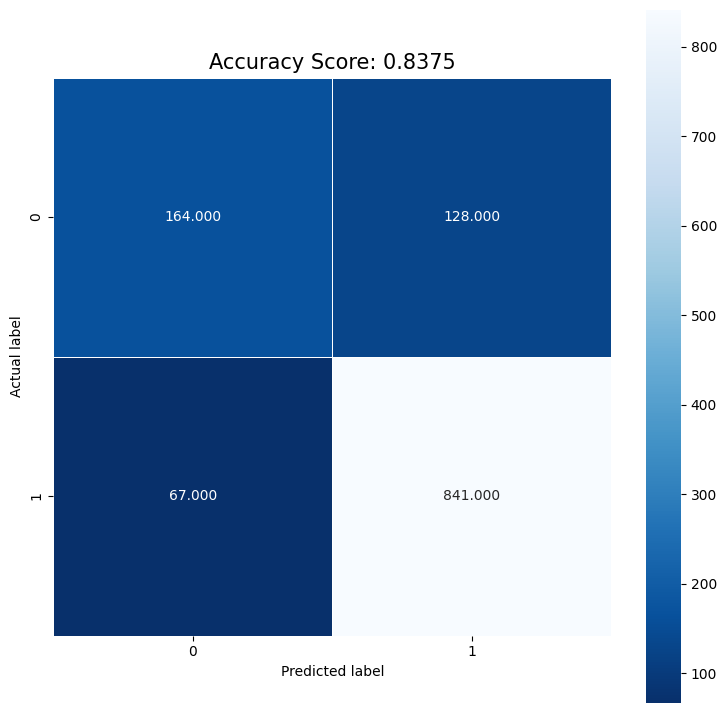

In [101]:
plt.figure(figsize=(9,9))
sns.heatmap(cm2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(adaboost_score)
plt.title(all_sample_title, size = 15);